C:\Users\frbla\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_base.py:121: FutureWarning: 'normalize' was deprecated in version 1.2 and will be removed in 1.4. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\frbla\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.025957948299979917
Number of non-zero weights: 4


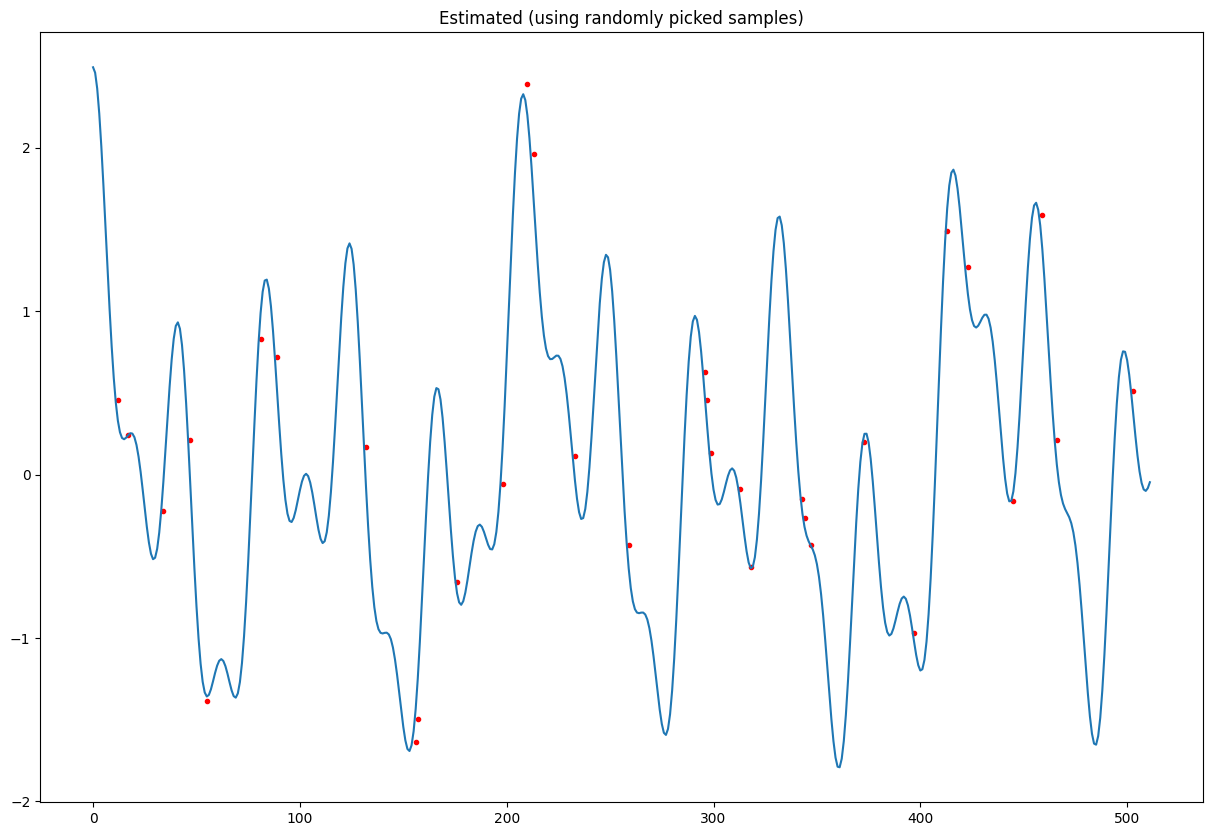

In [26]:
import librosa
import librosa.display
import IPython
import numpy as np
from scipy import linalg
from scipy import stats
import scipy.signal
from scipy.linalg import toeplitz
from scipy.signal import wiener
from scipy import signal
import matplotlib.pyplot as plt
import sounddevice as sd # only needed for playing
import soundfile as sf # only needed if playing does not work
from scipy.io import loadmat
from scipy import signal
from IPython.display import Audio
from scipy.fftpack import ifft, idct, dct
import math
from sklearn.linear_model import LassoLars, LassoLarsCV


problem= 'problem3_1'
matdata = loadmat(f'{problem}.mat')
n = matdata['n']
y = matdata['x']
l = 2**9;
N =len(x); 
# Construct the sensing matrix
B = np.zeros(shape=(N, l))
for i in range(0, N-1):
    B[i, n[i,:]-1] = 1

BF = idct(B, axis=1)  
# Use LassoLars
model = LassoLarsCV(fit_intercept=False, normalize=False,  max_iter=int(1e6))
model.fit(BF, y)
print(model.alpha_)
solsB = model.coef_
print(f'Number of non-zero weights: {np.count_nonzero(solsB)}')

# Take the inverse IDCT (i.e. the DCT) in order to compute the estimated signal.
x_hat = dct(solsB, axis=0)  

plt.figure(4, figsize=(15,10))
plt.plot(n, y, 'r.')
plt.title('Original + Samples taken')
plt.plot(x_hat)
plt.title('Estimated (using randomly picked samples)')
plt.show()
